# Data Sanity Check (V2)

In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns

# Add project root to path to allow importing from src
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data_management import (
    load_data,
    get_data_summary,
    verify_images,
    analyze_pneumonia_subtypes,
    check_for_data_leakage
)

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)

print("Setup complete. Downloading data...")
dataset_path = load_data()
print(f"\nDataset path: {dataset_path}")

c:\Users\Infin\Documents\GoogleDriveSync\Obsidian\Künstliche Intelligenz Labor\Project Phase\X-Ray Pneumonia Detection\X-Ray Pneumonia Detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Downloading data...
Ensuring data directory exists at: C:\Users\Infin\Documents\GoogleDriveSync\Obsidian\Künstliche Intelligenz Labor\Project Phase\X-Ray Pneumonia Detection\X-Ray Pneumonia Detection\data\raw
Initial download path: C:\Users\Infin\Documents\GoogleDriveSync\Obsidian\Künstliche Intelligenz Labor\Project Phase\X-Ray Pneumonia Detection\X-Ray Pneumonia Detection\data\raw\datasets\paultimothymooney\chest-xray-pneumonia\versions\2
Dataset ready. Root folder with train/test/val is: C:\Users\Infin\Documents\GoogleDriveSync\Obsidian\Künstliche Intelligenz Labor\Project Phase\X-Ray Pneumonia Detection\X-Ray Pneumonia Detection\data\raw\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray

Dataset path: C:\Users\Infin\Documents\GoogleDriveSync\Obsidian\Künstliche Intelligenz Labor\Project Phase\X-Ray Pneumonia Detection\X-Ray Pneumonia Detection\data\raw\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray


## 1. Data Loading & Structure / Class Imbalance

First, we confirm that the data is loaded correctly and count the number of images in each split (train, validation, test) and for each class (Normal, Pneumonia). This gives us an immediate look at the class balance.

Dataset Summary:
       NORMAL  PNEUMONIA  TOTAL
train    1341       3875   5216
val         8          8     16
test      234        390    624
TOTAL    1583       4273   5856


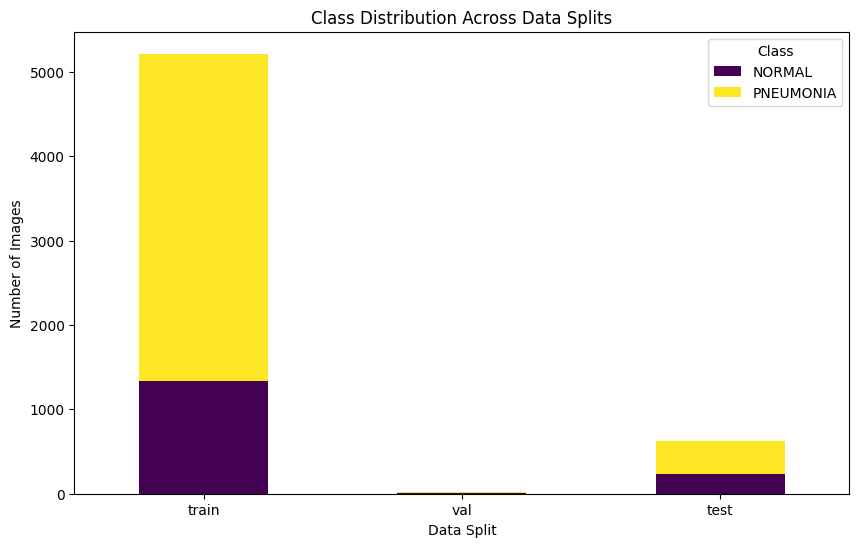

In [2]:
summary_df = get_data_summary(dataset_path)
print("Dataset Summary:")
print(summary_df)

# Plotting the class distribution
summary_df_to_plot = summary_df.drop('TOTAL').drop('TOTAL', axis=1)
ax = summary_df_to_plot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Class Distribution Across Data Splits')
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(title='Class')
plt.show()

## 2. Image Content & Format

We need to ensure the image files are valid and understand their properties, like dimensions and color format. We'll check a random sample of images.

In [3]:
image_verification_results, sample_paths = verify_images(dataset_path, num_samples_to_check=10000)

print(f"Corrupted files found: {len(image_verification_results['corrupted_files'])}")
if image_verification_results['corrupted_files']:
    print(image_verification_results['corrupted_files'])

print(f"\nColor mode counts (from a sample of {image_verification_results['total_checked']} images):")
for mode, count in image_verification_results['modes'].items():
    print(f"- {mode}: {count} images")

print(f"\nUnique dimensions found: {len(image_verification_results['dimensions'])} and a few examples are: {list(image_verification_results['dimensions'])[:5]}")

Corrupted files found: 0

Color mode counts (from a sample of 5856 images):
- L: 5573 images
- RGB: 283 images

Unique dimensions found: 4803 and a few examples are: [(976, 544), (848, 624), (1994, 1839), (1762, 1224), (1454, 1071)]


### Visualize Sample Images

Displaying random sample of images from the dataset...


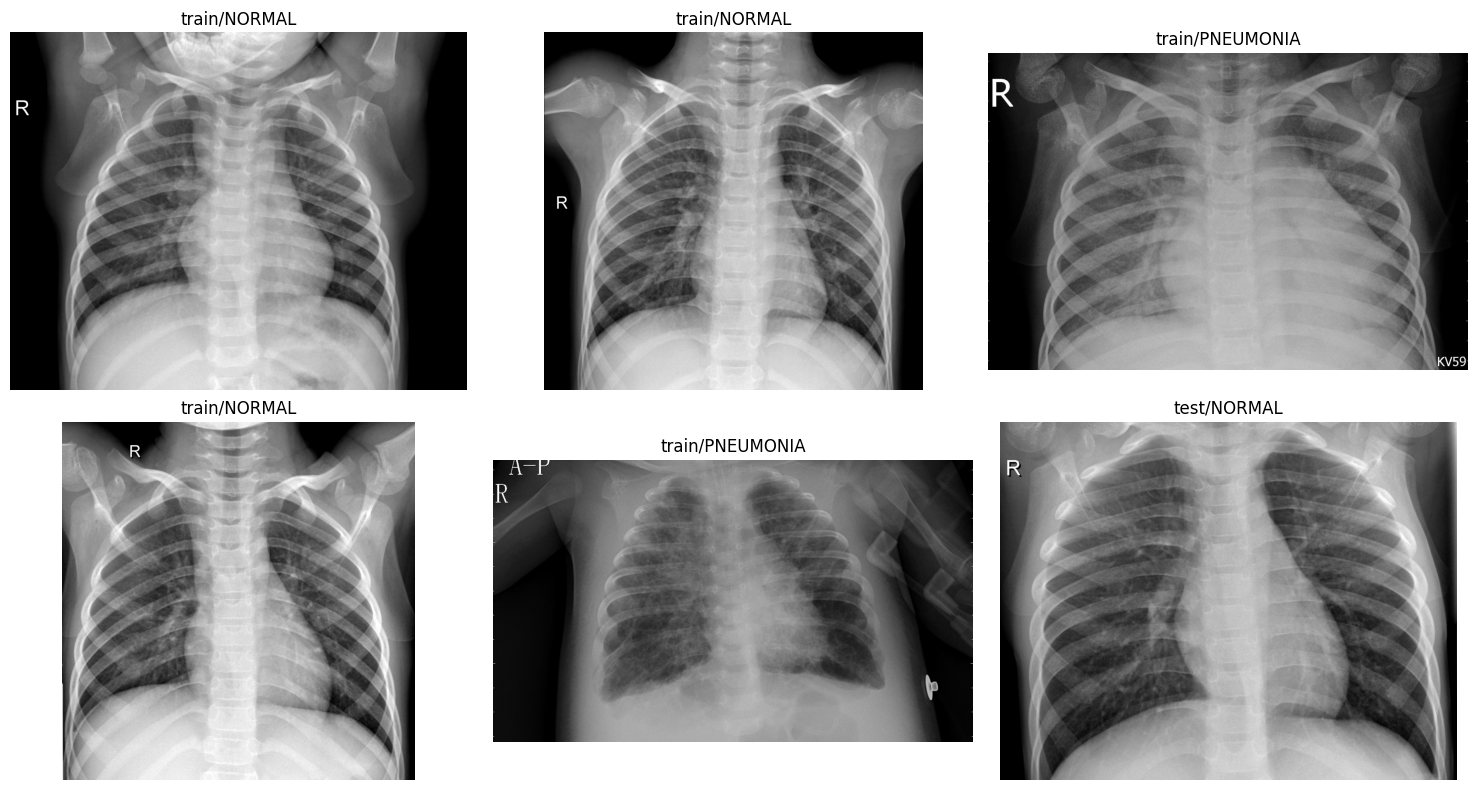

In [4]:
def show_sample_images(image_paths, num_to_show=6):
    if not image_paths:
        print("No images to display.")
        return
    
    plt.figure(figsize=(15, 8))
    num_to_show = min(len(image_paths), num_to_show)
    for i, img_path in enumerate(image_paths[:num_to_show]):
        plt.subplot(2, 3, i + 1)
        try:
            with Image.open(img_path) as img:
                plt.imshow(img, cmap='gray')
                class_name = img_path.parent.name
                split_name = img_path.parent.parent.name
                plt.title(f"{split_name}/{class_name}")
                plt.axis('off')
        except Exception as e:
            print(f"Could not load {img_path}: {e}")
    plt.tight_layout()
    plt.show()

print("Displaying random sample of images from the dataset...")
show_sample_images(sample_paths)

## 3. Label & Anomaly Verification

### Pneumonia Subtypes (Viral vs. Bacterial)
This helps us decide if a 3-class classification problem is feasible or if we should stick to a binary (Normal vs. Pneumonia) problem.

In [5]:
subtype_df, unknown_paths = analyze_pneumonia_subtypes(dataset_path)
print("Pneumonia Subtype Summary:")
print(subtype_df)

Pneumonia Subtype Summary:
       bacteria  virus  TOTAL
train      2530   1345   3875
val           8      0      8
test        242    148    390
TOTAL      2780   1493   4273


In [6]:
if unknown_paths:
    print(f"\nFound {len(unknown_paths)} images with unknown pneumonia subtype:")
    for path in unknown_paths:
        print(path.name)
    
    print("\nDisplaying unknown subtype images...")
    show_sample_images(unknown_paths)
else:
    print("\nNo unknown pneumonia subtypes found.")


No unknown pneumonia subtypes found.


### Check for Data Leakage
A critical step. We verify that no identical images exist across the `train`, `val`, and `test` sets. Even one leak can invalidate our test results.

In [7]:
leakage_results = check_for_data_leakage(dataset_path)
print("\nData Leakage Check Results:")
print(f"- Duplicates between train and val sets: {leakage_results['train_val']}")
print(f"- Duplicates between train and test sets: {leakage_results['train_test']}")
print(f"- Duplicates between val and test sets: {leakage_results['val_test']}")

Hashing files in 'train' set...
Hashing files in 'val' set...
Hashing files in 'test' set...
Comparing hash sets...

Data Leakage Check Results:
- Duplicates between train and val sets: 0
- Duplicates between train and test sets: 0
- Duplicates between val and test sets: 0


## 4. Distribution & Preprocessing

### Pixel Intensity Distribution

We look at the pixel value histograms for a few sample images. This helps us understand if we need specific normalization techniques like contrast adjustment, in addition to standard scaling.

In [ ]:
def plot_pixel_histograms(image_paths, num_to_show=6):
    if not image_paths:
        print("No images to display for this mode.")
        return
        
    plt.figure(figsize=(15, 8))
    num_to_show = min(len(image_paths), num_to_show)
    for i, img_path in enumerate(image_paths[:num_to_show]):
        plt.subplot(2, 3, i + 1)
        try:
            with Image.open(img_path) as img:
                img_gray = img.convert('L')
                pixel_values = np.array(img_gray).flatten()
                sns.histplot(pixel_values, bins=256, kde=False)
                class_name = img_path.parent.name
                plt.title(f'Hist for a {class_name} Image')
        except Exception as e:
            print(f"Could not process {img_path}: {e}")
    plt.tight_layout()
    plt.show()

#### RGB Image Histograms

Displaying pixel histograms for a random sample of 'RGB' images...


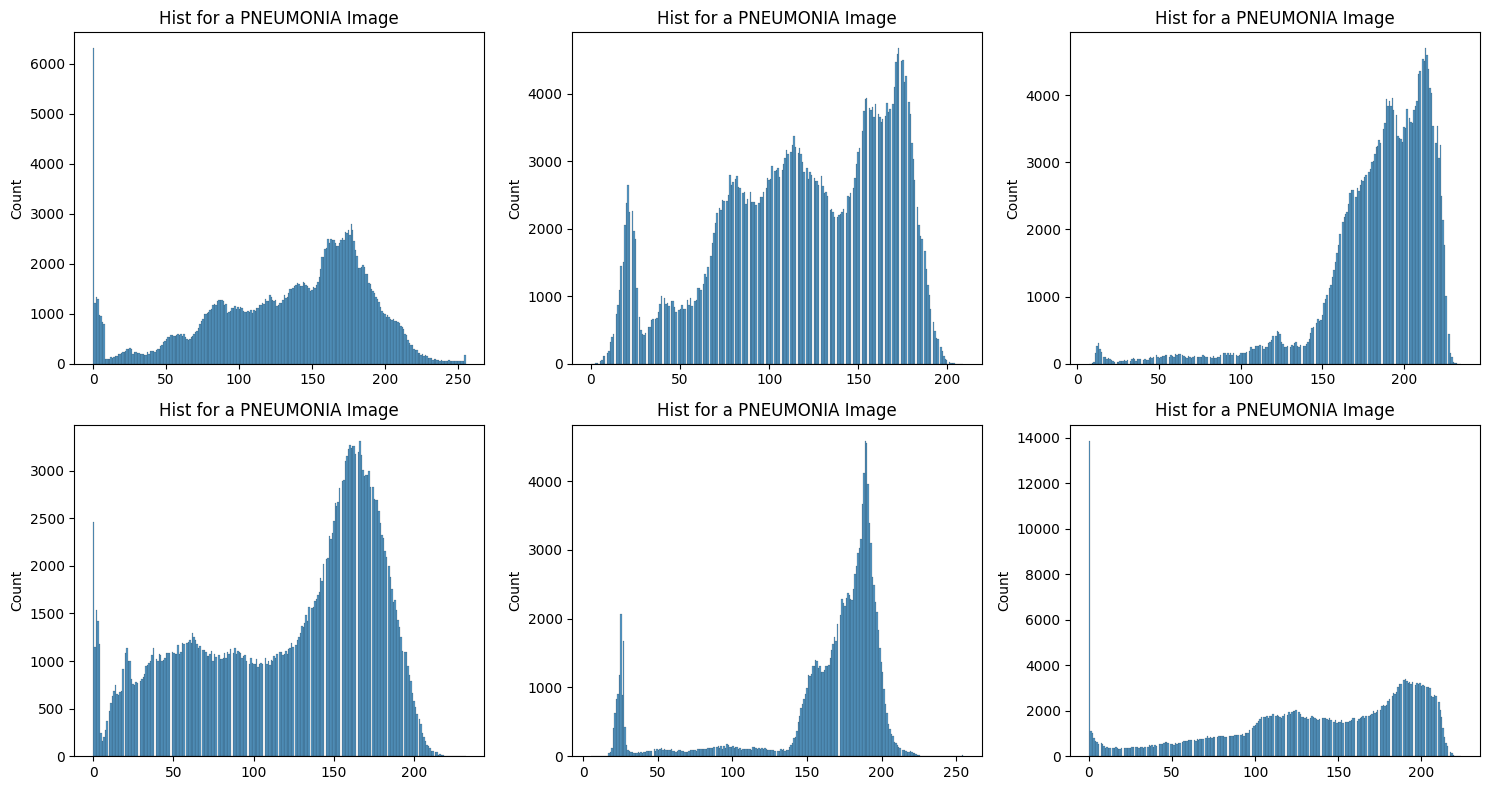

In [9]:
print("Displaying pixel histograms for a random sample of 'RGB' images...")
plot_pixel_histograms(image_verification_results['paths_by_mode']['RGB'])

#### Grayscale (L) Image Histograms

Displaying pixel histograms for a random sample of 'L' images...


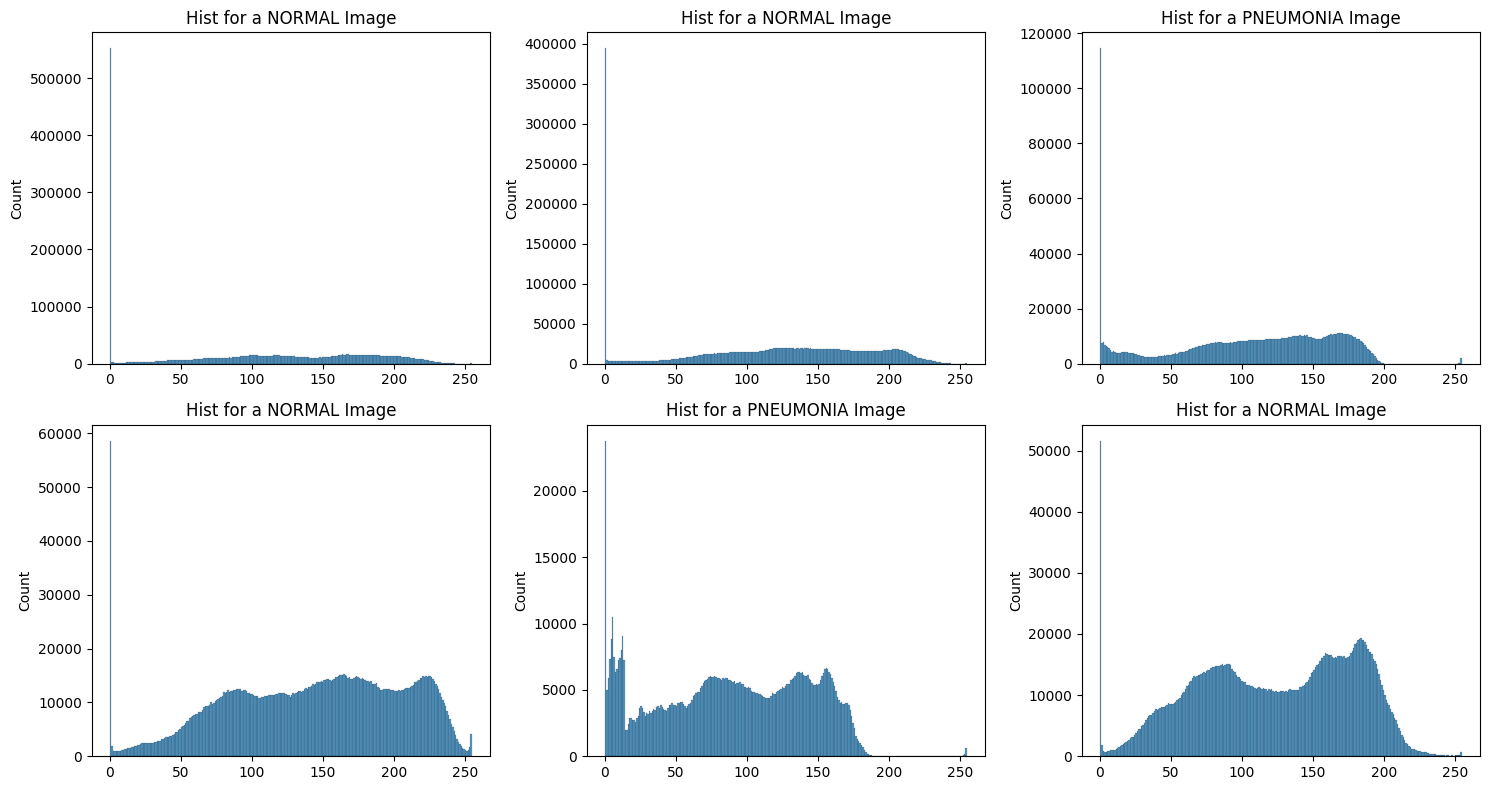

In [10]:
print("Displaying pixel histograms for a random sample of 'L' images...")
plot_pixel_histograms(image_verification_results['paths_by_mode']['L'])